# Statistical and Neural Forecasting methods
> In this notebook, you will make forecasts for the M5 dataset choosing the best model for each time series using cross validation.

In time series forecasting and analysis, it can be challenging to determine which model is best suited for a particular group of series. This decision often relies on intuition, which may not always align with reality.

In this tutorial, we will demonstrate a robust approach for selecting models for groups of series using the M5 benchmark dataset. We will train the following models:

- Baseline models: `SeasonalNaive` and `HistoricAverage`
- Intermittent models: `CrostonOptimized`, `IMAPA`, and `ADIDA`
- State Space Models: `AutoETS`
- Deep Learning: Transformers (`AutoTFT`) and Neural Networks (`AutoNHITS`) (from [NeuralForecast](https://github.com/Nixtla/neuralforecast))

By using the Nixtla libraries, we will be able to make more informed decisions on which models to use for specific groups of series in our dataset.

Outline:

* Read data
* Forecast the next 28 days using statiscal and deep learning methods
* Evaluate the models perfomance on different Windows
* Choose the best model for a group of series
* Filter the best possible forecast 

## Installing Libraries

In [1]:
%%capture
!pip install -U pandas statsforecast datasetsforecast s3fs pyarrow seaborn

## Download and prepare data

The example uses the [M5 dataset](https://github.com/Mcompetitions/M5-methods/blob/master/M5-Competitors-Guide.pdf). It consists of `30,490` bottom time series. 

In [2]:
import pandas as pd

In [3]:
Y_df = pd.read_parquet('https://m5-benchmarks.s3.amazonaws.com/data/train/target.parquet')


#Feature: The Nixtlaverse takes as input a df with id's, timestamps and values.
Y_df = Y_df.rename(columns={
    'item_id': 'unique_id', 
    'timestamp': 'ds', 
    'demand': 'y'
})

Y_df['ds'] = pd.to_datetime(Y_df['ds'])

For simplicity sake we will keep just one category

In [4]:
Y_df = Y_df[Y_df['unique_id'].str.startswith("FOODS_3")]
# only 30 series to make it faster
uids = Y_df['unique_id'].unique()[:30]
Y_df = Y_df.query('unique_id in @uids')
Y_df['unique_id'] = Y_df['unique_id'].astype(str)

In [5]:
Y_df['unique_id'].nunique()

30

In [6]:
Y_df.head()

,unique_id,ds,y
9204645,FOODS_3_001_CA_1,2011-01-29,1.0
9204646,FOODS_3_001_CA_1,2011-01-30,1.0
9204647,FOODS_3_001_CA_1,2011-01-31,1.0
9204648,FOODS_3_001_CA_1,2011-02-01,1.0
9204649,FOODS_3_001_CA_1,2011-02-02,1.0


# Basic Plotting

Plot some series using the plot method from the `StatsForecast` class. This method prints 8 random series from the dataset and is useful for basic [EDA](https://nixtla.github.io/statsforecast/core.html#statsforecast.plot).


In [7]:
from statsforecast import StatsForecast

/usr/local/lib/python3.8/dist-packages/statsforecast/core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [8]:
# Feature: plot random series for EDA
StatsForecast.plot(Y_df)

In [9]:
# Feature: plot groups of series for EDA
StatsForecast.plot(Y_df, unique_ids=["FOODS_3_003_CA_2"])

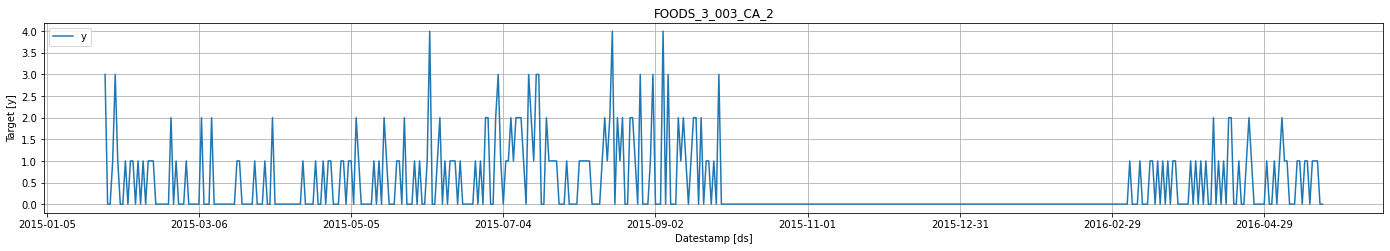

In [10]:
# Feature: plot groups of series for EDA
StatsForecast.plot(Y_df, unique_ids=["FOODS_3_003_CA_2"], engine ='matplotlib')

# Scalable Forecast 

## StatsForecast

`StatsForecast` offers a collection of popular univariate time series forecasting models optimized for high performance and scalability.

Features:

- Collection of local models. 
- Simple: training, forecasting and backtesting of many models in a few lines
- Optimized for speed
- Scales horizontally with Spark, Dask, Ray



`StatsForecast` receives a list of models to fit each time series. Since we are dealing with Daily data, it would be benefitial to use 7 as seasonality.

In [11]:
# Import models
from statsforecast.models import (
    SeasonalNaive,
    Naive,
    HistoricAverage,
    CrostonOptimized,
    ADIDA,
    IMAPA,
    AutoETS
)

We fit the models by instantiating a new StatsForecast object with the following parameters:

- `models`: a list of models. Select the models you want from models and import them.
- `freq`: a string indicating the frequency of the data. (See panda’s available frequencies.)
- `n_jobs`: n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores.
- `fallback_model`: a model to be used if a model fails.
Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

In [12]:
horizon = 28
models = [
    SeasonalNaive(season_length=7),
    Naive(),
    HistoricAverage(),
    CrostonOptimized(),
    ADIDA(),
    IMAPA(),
    AutoETS(season_length=7)
]

In [13]:
# Instantiate statsforecast class
sf = StatsForecast(
    models=models, 
    freq='D', 
    n_jobs=-1,
)

The forecast method takes two arguments: forecasts next h (horizon) and level.

- `h` (int): represents the forecast h steps into the future. In this case, 12 months ahead.
- `level` (list of floats): this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, level=[90] means that the model expects the real value to be inside that interval 90% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals.

In [14]:
from time import time

init = time()
fcst_df = sf.forecast(df=Y_df, h=28, level=[90])
end = time()
print(f'Forecast Minutes: {(end - init) / 60}')

Forecast Minutes: 0.9914215604464213


In [15]:
fcst_df.head()

,ds,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,Naive,Naive-lo-90,Naive-hi-90,HistoricAverage,HistoricAverage-lo-90,HistoricAverage-hi-90,CrostonOptimized,ADIDA,IMAPA,AutoETS,AutoETS-lo-90,AutoETS-hi-90
unique_id,,,,,,,,,,,,,,,,
FOODS_3_001_CA_1,2016-05-23,1.0,-2.847174,4.847174,2.0,0.098363,3.901637,0.448738,-1.009579,1.907055,0.345192,0.345477,0.347249,0.381414,-1.028122,1.790950
FOODS_3_001_CA_1,2016-05-24,0.0,-3.847174,3.847174,2.0,-0.689321,4.689321,0.448738,-1.009579,1.907055,0.345192,0.345477,0.347249,0.286933,-1.124136,1.698003
FOODS_3_001_CA_1,2016-05-25,0.0,-3.847174,3.847174,2.0,-1.293732,5.293732,0.448738,-1.009579,1.907055,0.345192,0.345477,0.347249,0.334987,-1.077614,1.747588
FOODS_3_001_CA_1,2016-05-26,1.0,-2.847174,4.847174,2.0,-1.803274,5.803274,0.448738,-1.009579,1.907055,0.345192,0.345477,0.347249,0.186851,-1.227280,1.600982
FOODS_3_001_CA_1,2016-05-27,0.0,-3.847174,3.847174,2.0,-2.252190,6.252190,0.448738,-1.009579,1.907055,0.345192,0.345477,0.347249,0.308112,-1.107548,1.723771


### Feature Support for distibuted engines

In [16]:
# You can use a ray, spark or dask cluster to
# scale your forecasting task
# simply pass a spark/ray or dask dataframe

## NeuralForecast

`NeuralForecast` offers a large collection of neural forecasting models focused on their usability, and robustness. The models range from classic networks like MLP, RNNs to novel proven contributions like NBEATS, NHITS, TFT and other architectures.

Features:

* Collection of global models. 
* Simple: training, forecasting and backtesing of many models in a few lines. 
* GPU Support

This machine doesn't have GPU, but Google Colabs offers some for free. 

Using [Colab's GPU to train NeuralForecast](https://nixtla.github.io/neuralforecast/examples/intermittentdata.html).


In [17]:
# Read the results from Colab
fcst_nf_df = pd.read_parquet('https://m5-benchmarks.s3.amazonaws.com/data/forecast-nf.parquet')

In [18]:
fcst_nf_df.head()

,unique_id,ds,AutoNHITS,AutoNHITS-lo-90,AutoNHITS-hi-90,AutoTFT,AutoTFT-lo-90,AutoTFT-hi-90
0,FOODS_3_001_CA_1,2016-05-23,0.0,0.0,2.0,0.0,0.0,2.0
1,FOODS_3_001_CA_1,2016-05-24,0.0,0.0,2.0,0.0,0.0,2.0
2,FOODS_3_001_CA_1,2016-05-25,0.0,0.0,2.0,0.0,0.0,1.0
3,FOODS_3_001_CA_1,2016-05-26,0.0,0.0,2.0,0.0,0.0,2.0
4,FOODS_3_001_CA_1,2016-05-27,0.0,0.0,2.0,0.0,0.0,2.0


In [19]:
# Merge the two dataframes. 
fcst_df = fcst_df.merge(fcst_nf_df, how='left', on=['unique_id', 'ds'])

In [20]:
fcst_df.head()

,unique_id,ds,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,Naive,Naive-lo-90,Naive-hi-90,HistoricAverage,HistoricAverage-lo-90,...,IMAPA,AutoETS,AutoETS-lo-90,AutoETS-hi-90,AutoNHITS,AutoNHITS-lo-90,AutoNHITS-hi-90,AutoTFT,AutoTFT-lo-90,AutoTFT-hi-90
0,FOODS_3_001_CA_1,2016-05-23,1.0,-2.847174,4.847174,2.0,0.098363,3.901637,0.448738,-1.009579,...,0.347249,0.381414,-1.028122,1.790950,0.0,0.0,2.0,0.0,0.0,2.0
1,FOODS_3_001_CA_1,2016-05-24,0.0,-3.847174,3.847174,2.0,-0.689321,4.689321,0.448738,-1.009579,...,0.347249,0.286933,-1.124136,1.698003,0.0,0.0,2.0,0.0,0.0,2.0
2,FOODS_3_001_CA_1,2016-05-25,0.0,-3.847174,3.847174,2.0,-1.293732,5.293732,0.448738,-1.009579,...,0.347249,0.334987,-1.077614,1.747588,0.0,0.0,2.0,0.0,0.0,1.0
3,FOODS_3_001_CA_1,2016-05-26,1.0,-2.847174,4.847174,2.0,-1.803274,5.803274,0.448738,-1.009579,...,0.347249,0.186851,-1.227280,1.600982,0.0,0.0,2.0,0.0,0.0,2.0
4,FOODS_3_001_CA_1,2016-05-27,0.0,-3.847174,3.847174,2.0,-2.252190,6.252190,0.448738,-1.009579,...,0.347249,0.308112,-1.107548,1.723771,0.0,0.0,2.0,0.0,0.0,2.0


## Forecast plots

In [21]:
sf.plot(Y_df, fcst_df, max_insample_length=28 * 3)

Use the plot function to explore models and ID's

In [22]:
sf.plot(Y_df, fcst_df, max_insample_length=28 * 3, 
        models=['CrostonOptimized', 'AutoNHITS', 'SeasonalNaive'])

# Validate Model's Performance

Both `StatsForecast` and `NeuralForecast` offer out of the box cross validation for time series.


![From the course of Modern Forecasting in Practice](https://github.com/Nixtla/statsforecast/blob/main/nbs/imgs/cv-sphere.png?raw=1)

## StatsForecast

The `cross_validation` method from the `StatsForecast` class takes the following arguments.

- `df`: training data frame
- `h` (int): represents h steps into the future that are being forecasted. In this case, 24 hours ahead.
- `step_size` (int): step size between each window. In other words: how often do you want to run the forecasting processes.
- `n_windows` (int): number of windows used for cross validation. In other words: what number of forecasting processes in the past do you want to evaluate.

In [23]:
init = time()
cv_df = sf.cross_validation(df=Y_df, h=horizon, n_windows=3, step_size=horizon, level=[90])
end = time()
print(f'CV Minutes: {(end - init) / 60}')

CV Minutes: 1.348125942548116


The crossvaldation_df object is a new data frame that includes the following columns:

- `unique_id` index: (If you dont like working with index just run forecasts_cv_df.resetindex())
- `ds`: datestamp or temporal index
- `cutoff`: the last datestamp or temporal index for the n_windows. If n_windows=1, then one unique cuttoff value, if n_windows=2 then two unique cutoff values.
- `y`: true value
- `"model"`: columns with the model’s name and fitted value.

In [24]:
cv_df.head()

,ds,cutoff,y,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,Naive,Naive-lo-90,Naive-hi-90,HistoricAverage,HistoricAverage-lo-90,HistoricAverage-hi-90,CrostonOptimized,ADIDA,IMAPA,AutoETS,AutoETS-lo-90,AutoETS-hi-90
unique_id,,,,,,,,,,,,,,,,,,
FOODS_3_001_CA_1,2016-02-29,2016-02-28,0.0,2.0,-1.878885,5.878885,0.0,-1.917011,1.917011,0.449111,-1.021813,1.920036,0.618472,0.618375,0.617998,0.655286,-0.765731,2.076302
FOODS_3_001_CA_1,2016-03-01,2016-02-28,1.0,0.0,-3.878885,3.878885,0.0,-2.711064,2.711064,0.449111,-1.021813,1.920036,0.618472,0.618375,0.617998,0.568595,-0.853966,1.991155
FOODS_3_001_CA_1,2016-03-02,2016-02-28,1.0,0.0,-3.878885,3.878885,0.0,-3.320361,3.320361,0.449111,-1.021813,1.920036,0.618472,0.618375,0.617998,0.618805,-0.805298,2.042908
FOODS_3_001_CA_1,2016-03-03,2016-02-28,0.0,1.0,-2.878885,4.878885,0.0,-3.834023,3.834023,0.449111,-1.021813,1.920036,0.618472,0.618375,0.617998,0.455891,-0.969753,1.881534
FOODS_3_001_CA_1,2016-03-04,2016-02-28,0.0,1.0,-2.878885,4.878885,0.0,-4.286568,4.286568,0.449111,-1.021813,1.920036,0.618472,0.618375,0.617998,0.591197,-0.835987,2.018380


## NeuralForecast

This machine doesn't have GPU, but Google Colabs offers some for free. 

Using [Colab's GPU to train NeuralForecast](https://nixtla.github.io/neuralforecast/examples/intermittentdata.html).


In [25]:
cv_nf_df = pd.read_parquet('https://m5-benchmarks.s3.amazonaws.com/data/cross-validation-nf.parquet')

In [26]:
cv_nf_df.head()

,unique_id,ds,cutoff,AutoNHITS,AutoNHITS-lo-90,AutoNHITS-hi-90,AutoTFT,AutoTFT-lo-90,AutoTFT-hi-90,y
0,FOODS_3_001_CA_1,2016-02-29,2016-02-28,0.0,0.0,2.0,1.0,0.0,2.0,0.0
1,FOODS_3_001_CA_1,2016-03-01,2016-02-28,0.0,0.0,2.0,1.0,0.0,2.0,1.0
2,FOODS_3_001_CA_1,2016-03-02,2016-02-28,0.0,0.0,2.0,1.0,0.0,2.0,1.0
3,FOODS_3_001_CA_1,2016-03-03,2016-02-28,0.0,0.0,2.0,1.0,0.0,2.0,0.0
4,FOODS_3_001_CA_1,2016-03-04,2016-02-28,0.0,0.0,2.0,1.0,0.0,2.0,0.0


## Merge cross validation forecasts

In [27]:
cv_df = cv_df.merge(cv_nf_df.drop(columns=['y']), how='left', on=['unique_id', 'ds', 'cutoff'])

## Plots CV

In [28]:
cutoffs = cv_df['cutoff'].unique()

In [29]:
for cutoff in cutoffs:
    sf.plot(Y_df, 
            cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']), 
            max_insample_length=28 * 5, 
            unique_ids=['FOODS_3_001_CA_1'])

### Aggregate Demand

In [30]:
agg_cv_df = cv_df.loc[:,~cv_df.columns.str.contains('hi|lo')].groupby(['ds', 'cutoff']).sum(numeric_only=True).reset_index()
agg_cv_df.insert(0, 'unique_id', 'agg_demand')

In [31]:
agg_Y_df = Y_df.groupby(['ds']).sum(numeric_only=True).reset_index()
agg_Y_df.insert(0, 'unique_id', 'agg_demand')

In [32]:
for cutoff in cutoffs:
    sf.plot(agg_Y_df, 
            agg_cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']),
            max_insample_length=28 * 5)

## Evaluation per series and CV window

In this section we will evaluate the performance of each model for each time series and each cross validation window. Since we have many combinations, we will use `dask` to parallelize the evaluation. The parallelization will be done using `fugue`.

In [33]:
from typing import List, Callable

from distributed import Client
from fugue import transform
from fugue_dask import DaskExecutionEngine
from datasetsforecast.losses import mse, mae, smape

The `evaluate` function receives a unique combination of a time series and a window, and calculates different `metrics` for each model in `df`.

In [34]:
def evaluate(df: pd.DataFrame, metrics: List[Callable]) -> pd.DataFrame:
    eval_ = {}
    models = df.loc[:, ~df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
    for model in models:
        eval_[model] = {}
        for metric in metrics:
            eval_[model][metric.__name__] = metric(df['y'], df[model])
    eval_df = pd.DataFrame(eval_).rename_axis('metric').reset_index()
    eval_df.insert(0, 'cutoff', df['cutoff'].iloc[0])
    eval_df.insert(0, 'unique_id', df['unique_id'].iloc[0])
    return eval_df

In [35]:
str_models = cv_df.loc[:, ~cv_df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
str_models = ','.join([f"{model}:float" for model in str_models])
cv_df['cutoff'] = cv_df['cutoff'].astype(str)
cv_df['unique_id'] = cv_df['unique_id'].astype(str)

Let's cleate a `dask` client.

The `transform` function takes the `evaluate` functions and applies it to each combination of time series (`unique_id`) and cross validation window (`cutoff`) using the `dask` client we created before.

In [36]:
evaluation_df = transform(
    cv_df.loc[:, ~cv_df.columns.str.contains('lo|hi')], 
    evaluate, 
    params={'metrics': [mse, mae, smape]}, 
    schema=f"unique_id:str,cutoff:str,metric:str, {str_models}", 
    as_local=True,
    partition={'by': ['unique_id', 'cutoff']}
)

In [37]:
evaluation_df.head()

,unique_id,cutoff,metric,SeasonalNaive,Naive,HistoricAverage,CrostonOptimized,ADIDA,IMAPA,AutoETS,AutoNHITS,AutoTFT
0,FOODS_3_001_CA_1,2016-02-28,mse,1.071429,0.928571,0.552844,0.515901,0.515905,0.515924,0.495400,0.785714,0.607143
1,FOODS_3_001_CA_1,2016-02-28,mae,0.857143,0.642857,0.610778,0.598681,0.598687,0.598714,0.574798,0.642857,0.535714
2,FOODS_3_001_CA_1,2016-02-28,smape,132.142853,107.142853,137.963226,123.216461,123.224007,123.253609,122.359123,110.714279,91.666664
3,FOODS_3_001_CA_1,2016-03-27,mse,2.000000,0.857143,0.609448,0.649203,0.641414,0.674665,0.615575,0.857143,0.857143
4,FOODS_3_001_CA_1,2016-03-27,mae,1.000000,0.785714,0.629140,0.701453,0.695750,0.717100,0.682166,0.785714,0.785714


In [38]:
# Calculate the mean metric for each cross validation window
evaluation_df.groupby(['cutoff', 'metric']).mean(numeric_only=True)

SeasonalNaive       Naive  HistoricAverage  \
cutoff     metric                                               
2016-02-28 mae          1.471429    1.938095         1.648166   
           mse          7.228571   12.757143         9.506728   
           smape      101.874054  104.193626       155.250412   
2016-03-27 mae          0.580952    0.469048         1.815362   
           mse          1.321429    0.869048        11.853115   
           smape       61.578236   61.315193       165.832825   
2016-04-24 mae          1.221429    1.192857         1.350950   
           mse          6.797619    6.642857         6.363796   
           smape       91.448982   90.692749       141.539032   

                   CrostonOptimized       ADIDA       IMAPA     AutoETS  \
cutoff     metric                                                         
2016-02-28 mae             1.512684    1.484476    1.491135    1.477039   
           mse             5.938166    6.430810    6.459065    6.289412   
           smape         151.784912  169.300735  169.479431  169.415466   
2016-03-27 mae             1.725589    0.519376    0.516225    0.641433   
           mse            10.110158    0.669760    0.668919    0.848791   
           smape         174.082764  163.459778  163.474045  163.777191   
2016-04-24 mae             1.310497    1.169714    1.168038    1.252849   
           mse             5.860662    6.339518    6.342854    6.705260   
           smape         142.072968  164.926331  165.521545  163.752716   

                    AutoNHITS     AutoTFT  
cutoff     metric                          
2016-02-28 mae       1.363095    1.427976  
           mse       5.629762    6.164583  
           smape   104.478294  104.201797  
2016-03-27 mae       0.804167    0.809524  
           mse       1.752083    1.895833  
           smape    93.511337   94.069168  
2016-04-24 mae       1.101786    1.121429  
           mse       6.429464    6.373214  
           smape    83.753975   89.142853

### Distribution of errors

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
evaluation_df_melted = pd.melt(evaluation_df, id_vars=['unique_id', 'cutoff', 'metric'], var_name='model', value_name='error')

In [41]:
evaluation_df_melted

,unique_id,cutoff,metric,model,error
0,FOODS_3_001_CA_1,2016-02-28,mse,SeasonalNaive,1.071429
1,FOODS_3_001_CA_1,2016-02-28,mae,SeasonalNaive,0.857143
2,FOODS_3_001_CA_1,2016-02-28,smape,SeasonalNaive,132.142853
3,FOODS_3_001_CA_1,2016-03-27,mse,SeasonalNaive,2.000000
4,FOODS_3_001_CA_1,2016-03-27,mae,SeasonalNaive,1.000000
...,...,...,...,...,...
2425,FOODS_3_003_WI_3,2016-03-27,mae,AutoTFT,0.928571
2426,FOODS_3_003_WI_3,2016-03-27,smape,AutoTFT,142.380966
2427,FOODS_3_003_WI_3,2016-04-24,mse,AutoTFT,0.000000
2428,FOODS_3_003_WI_3,2016-04-24,mae,AutoTFT,0.000000


#### SMAPE

<AxesSubplot:xlabel='error', ylabel='model'>

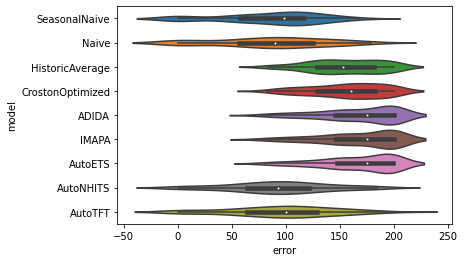

In [42]:
sns.violinplot(evaluation_df_melted.query('metric=="smape"'), x='error', y='model')

### Choose models for groups of series

Feature: 

* A unified dataframe with forecasts for all different models
* Easy Ensamble
* E.g. Average predictions
* Or MinMax (Choosing is ensembling)

In [43]:
pd.__version__

'1.5.3'

<AxesSubplot:xlabel='n', ylabel='best_model'>

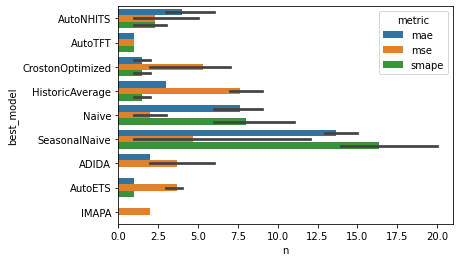

In [46]:
# Choose the best model for each time series, metric, and cross validation window
evaluation_df['best_model'] = evaluation_df.idxmin(axis=1, numeric_only=True)
# count how many times a model wins per metric and cross validation window
count_best_model = evaluation_df.groupby(['cutoff', 'metric', 'best_model']).size().rename('n').to_frame().reset_index()
# plot results
sns.barplot(count_best_model, x='n', y='best_model', hue='metric')

### Et pluribus unum: an inclusive forecasting Pie.

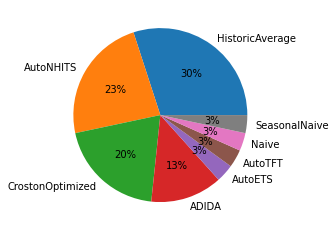

In [47]:
# For the mse, calculate how many times a model wins
eval_series_df = evaluation_df.query('metric == "mse"').groupby(['unique_id']).mean(numeric_only=True)
eval_series_df['best_model'] = eval_series_df.idxmin(axis=1)
counts_series = eval_series_df.value_counts('best_model')
plt.pie(counts_series, labels=counts_series.index, autopct='%.0f%%')
plt.show()

In [48]:
sf.plot(Y_df, cv_df.drop(columns=['cutoff', 'y']), 
        max_insample_length=28 * 6, 
        models=['AutoNHITS'],
        unique_ids=eval_series_df.query('best_model == "AutoNHITS"').index[:8])

# Choose Forecasting method for different groups of series

In [49]:
# Merge the best model per time series dataframe
# and filter the forecasts based on that dataframe
# for each time series
fcst_df = pd.melt(fcst_df.set_index('unique_id'), id_vars=['ds'], var_name='model', value_name='forecast', ignore_index=False)
fcst_df = fcst_df.join(eval_series_df[['best_model']])
fcst_df[['model', 'pred-interval']] = fcst_df['model'].str.split('-', expand=True, n=1)
fcst_df = fcst_df.query('model == best_model')
fcst_df['name'] = [f'forecast-{x}' if x is not None else 'forecast' for x in fcst_df['pred-interval']]
fcst_df = pd.pivot_table(fcst_df, index=['unique_id', 'ds'], values=['forecast'], columns=['name']).droplevel(0, axis=1).reset_index()

<ipython-input-49-d757190b552a>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [50]:
sf.plot(Y_df, fcst_df, max_insample_length=28 * 3)

# Technical Debt

- Train the statistical models in the full dataset.
- Increase the number of `num_samples` in the neural auto models.
- Include other models such as `Theta`, `ARIMA`, `RNN`, `LSTM`, ...

# Further materials

- [Available Models StatsForecast](https://nixtla.github.io/statsforecast/examples/models_intro.html)
- [Available Models NeuralForecast](https://nixtla.github.io/neuralforecast/models.html)
- [Scalers and Loss Functions](https://nixtla.github.io/neuralforecast/losses.pytorch.html)
- [Getting Started NeuralForecast](https://nixtla.github.io/neuralforecast/examples/getting_started.html)
- [Hierarchical Reconciliation](https://nixtla.github.io/hierarchicalforecast/examples/tourismsmall.html)
- [Distributed ML Forecast (trees)](https://nixtla.github.io/mlforecast/docs/quick_start_distributed.html)
- [Using StatsForecast to train millions of time series](https://www.anyscale.com/blog/how-nixtla-uses-ray-to-accurately-predict-more-than-a-million-time-series)
- [Intermittent Demand Forecasting With Nixtla on Databricks](https://www.databricks.com/blog/2022/12/06/intermittent-demand-forecasting-nixtla-databricks.html)